#  <h1><center>Grocery Sales Forcesting for Supermarket</center></h1>

<img src="header.png">

Img Source: Kaggle.com

## Table of Contents

1. Abstract

2. Introduction

3. Data Sources

   3.a. Data Loading
   
   3.b. Anamoly Detection
   
   3.c. Data Preparation and Data Cleaning
   
4. Analyzing Impact of Oil on the Sales

5. Data Blending

6. Product Purchase Trend

   6.a Fetching N most purchased products

7. Exploratory Data Analysis

8. Data Transformation

   8.a. One Hot Encoding
   
9. Regression Techniques
   9.a Linear Regression
   
   9.b Decision Tree Regressors
   
   9.c Extra Tree Regressors
   
   9.d Random Forest Regressors
   
   9.e Gradient Boosting Regressors
   
   9.f XGBoost
   
10. Light Gradient Boosting Method (LGBM)

11. Creating Neural Network

12. Conclusion

13. References and Attributions



# 1. Abstract

<img src="Forecast.jpg">

Product sales forecasting is a major aspect of purchasing management. Forecasts are crucial in
determining inventory stock levels, and accurately estimating future demand for goods has been an
ongoing challenge, especially in the Supermarkets and Grocery Stores industry. If goods are not readily
available or goods availability is more than demand overall profit can be compromised. As a result, sales
forecasting for goods can be significant to ensure loss is minimized. Additionally, the problem becomes
more complex as retailers add new locations with unique needs, new products, ever transitioning
seasonal tastes, and unpredictable product marketing. In this analysis, a forecasting model is developed
using machine learning algorithms to improve the accurately forecasts product sales. The proposed
model is especially targeted to support the future purchase and more accurate forecasts product sales
and is not intended to change current subjective forecasting methods. A model based on a real grocery
store's data is developed in order to validate the use of the various machine learning algorithms. In the
case study, multiple regression methods are compared. The methods impact on forecast product
availability in store to ensure they have just enough products at right time.

## The aim of this project is to forecast more accurate product sales for the Ecuadorian supermarket chain based on certain features.


# 2. Introduction

In this project, we are trying to forecasts product sales based on the items, stores, transaction and other
dependent variables like holidays and oil prices.

This is a Kaggle Competition called "Corporación Favorita Grocery Sales Forecasting" where the task is to
predict stocking of products to better ensure grocery stores please customers by having just enough of
the right products at the right time.

For this particular problem, we have analyzed the data as a supervised learning problem. In order to
forecasts the sales we have compared different regression models like Linear Regression, Decision Tree,
ExtraTreeRegressor, Gradient Boosting, Random Forest and XgBoost. Further to optimize the results we
have used multilayer perception (MLP: a class of feed forward artificial neural network) and LightGBM (
gradient boosting framework that uses tree based learning algorithms).

The data comes in the shape of multiple files. First, the training data (train.csv) essentially contains the sales by date, store, and item. The test data (test.csv) contains the same features without the sales information, which we are tasked to predict. The train vs test split is based on the date. In addition, some test items are not included in the train data.

<img src="background.jpg">

In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Loading all the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder,minmax_scale,PolynomialFeatures,StandardScaler,Normalizer
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
import matplotlib.pyplot as plt
from scipy.stats import itemfreq
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
#from sklearn.model_selection import train_test_split
%matplotlib inline
import datetime
from datetime import date, timedelta
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import keras
import sys
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
import lightgbm as lgb

# 3. Data Sources
There are 5 additional data files that provide the following information:

-- stores.csv : Details about the stores, such as location and type.

-- items.csv: Item metadata, such as class and whether they are perishable. Note, that perishable items have a higher scoring weight than others.

-- transactions.csv: Count of sales transactions for the training data

-- oil.csv: Daily oil price. This is relevant, because “Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.” (source)

-- holidays_events.csv: Holidays in Ecuador. Some holidays can be transferred to another day (possibly from weekend to weekday).


<img src="Capture1.jpg">


The text in the document by Source Kaggle is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/


# 3.a. Data Loading

In [15]:
#Loading the data
dtypes = {'store_nbr': np.dtype('int64'),
          'item_nbr': np.dtype('int64'),
          'unit_sales': np.dtype('float64'),
          'onpromotion': np.dtype('O')}

Sales = pd.read_csv('train.csv', dtype=dtypes)
test = pd.read_csv('test.csv', dtype=dtypes)
stores = pd.read_csv('stores.csv')
items = pd.read_csv('items.csv')
trans = pd.read_csv('transactions.csv')
#oil = pd.read_csv('../input/oil.csv') #we upload this database later
holidays = pd.read_csv('holidays_events.csv')

In [16]:
#sampling the data, since the data is too huge to carry put any operations
date_mask = (Sales['date'] >= '2017-07-15') & (Sales['date'] <= '2017-08-15')

Salesdf = Sales[date_mask]

#Print the size
len(Salesdf)

3359566

# 3.b. Anamoly Detection

In [18]:
#Load the data
oil = pd.read_csv('oil.csv')

#add missing date
min_oil_date = min(Salesdf.date)
max_oil_date = max(Salesdf.date)

calendar = []

d1 = datetime.datetime.strptime(min_oil_date, '%Y-%m-%d')  # start date
d2 = datetime.datetime.strptime(max_oil_date, '%Y-%m-%d')  # end date

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    calendar.append(datetime.date.strftime(d1 + timedelta(days=i), '%Y-%m-%d'))

calendar = pd.DataFrame({'date':calendar})

oil = calendar.merge(oil, left_on='date', right_on='date', how='left')

In [19]:
oil.head()

,date,dcoilwtico
0,2017-07-15,NaN
1,2017-07-16,NaN
2,2017-07-17,46.02
3,2017-07-18,46.40
4,2017-07-19,47.10


# 3.c Data Preparation and Data Cleaning

In [23]:
#Check how many NA
print(oil.isnull().sum(), '\n')

#Type


print('Type : ', '\n', oil.dtypes)

#Print the 3 first line
oil.head(5)

date          0
dcoilwtico    0
dtype: int64 

Type :  
 date           object
dcoilwtico    float64
dtype: object


,date,dcoilwtico
0,2017-07-15,46.02
1,2017-07-16,46.02
2,2017-07-17,46.02
3,2017-07-18,46.40
4,2017-07-19,47.10


# 4. Analyzing Impact of Oil on the sales of other products

In [24]:
#Check index to apply the formula
na_index_oil = oil[oil['dcoilwtico'].isnull() == True].index.values

#Define the index to use to apply the formala
na_index_oil_plus = na_index_oil.copy()
na_index_oil_minus = np.maximum(0, na_index_oil-1)

for i in range(len(na_index_oil)):
    k = 1
    while (na_index_oil[min(i+k,len(na_index_oil)-1)] == na_index_oil[i]+k):
        k += 1
    na_index_oil_plus[i] = min(len(oil)-1, na_index_oil_plus[i] + k )

#Apply the formula
for i in range(len(na_index_oil)):
    if (na_index_oil[i] == 0):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_plus[i], 'dcoilwtico']
    elif (na_index_oil[i] == len(oil)):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_minus[i], 'dcoilwtico']
    else:
        oil.loc[na_index_oil[i], 'dcoilwtico'] = (oil.loc[na_index_oil_plus[i], 'dcoilwtico'] + oil.loc[na_index_oil_minus[i], 'dcoilwtico'])/ 2   

In [25]:
oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

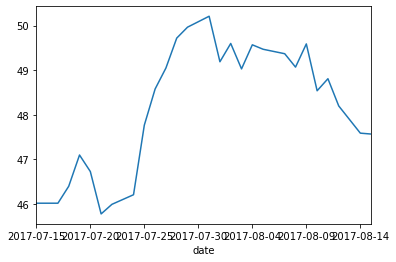

In [26]:
#Plot the oil values
oil_plot = oil['dcoilwtico'].copy()
oil_plot.index = oil['date'].copy()
oil_plot.plot()
plt.show()

# By the end of the analysis it is evident that the sale of oil as an important commodity has a significant impact on the unit sales of other products.

The text in the document by Source Wikipedia is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

The text in the document by Analytics Vidhya is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

The code in the document by Source Kaggle is licensed under the MIT License https://opensource.org/licenses/MIT

# 5. Data Blending

In [27]:
#Merge train
Salesdf = Salesdf.drop('id', axis = 1)
Salesdf = Salesdf.merge(stores, left_on='store_nbr', right_on='store_nbr', how='left')
Salesdf = Salesdf.merge(items, left_on='item_nbr', right_on='item_nbr', how='left')
Salesdf = Salesdf.merge(holidays, left_on='date', right_on='date', how='left')
Salesdf = Salesdf.merge(oil, left_on='date', right_on='date', how='left')
Salesdf = Salesdf.drop(['description', 'state', 'locale_name', 'class'], axis = 1)

In [28]:
Salesdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3359566 entries, 0 to 3359565
Data columns (total 14 columns):
date           object
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    object
city           object
type_x         object
cluster        int64
family         object
perishable     int64
type_y         object
locale         object
transferred    object
dcoilwtico     float64
dtypes: float64(2), int64(4), object(8)
memory usage: 384.5+ MB


In [29]:
Salesdf.isnull().sum().sort_values(ascending=False)

transferred    2626056
locale         2626056
type_y         2626056
dcoilwtico           0
perishable           0
family               0
cluster              0
type_x               0
city                 0
onpromotion          0
unit_sales           0
item_nbr             0
store_nbr            0
date                 0
dtype: int64

In [30]:
#Shape
print('Shape : ', Salesdf.shape, '\n')

#Type
print('Type : ', '\n', Salesdf.dtypes)

#Summary
Salesdf.describe()

Shape :  (3359566, 14) 

Type :  
 date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion     object
city            object
type_x          object
cluster          int64
family          object
perishable       int64
type_y          object
locale          object
transferred     object
dcoilwtico     float64
dtype: object


,store_nbr,item_nbr,unit_sales,cluster,perishable,dcoilwtico
count,3.359566e+06,3.359566e+06,3.359566e+06,3.359566e+06,3.359566e+06,3.359566e+06
mean,2.831059e+01,1.171591e+06,8.053185e+00,8.703191e+00,2.580432e-01,4.814635e+01
std,1.630974e+01,5.871905e+05,2.371664e+01,4.566465e+00,4.375579e-01,1.468388e+00
min,1.000000e+00,9.699500e+04,-2.410000e+02,1.000000e+00,0.000000e+00,4.578000e+01
25%,1.300000e+01,6.925310e+05,2.000000e+00,5.000000e+00,0.000000e+00,4.640000e+01
50%,2.900000e+01,1.212452e+06,4.000000e+00,9.000000e+00,0.000000e+00,4.858000e+01
75%,4.400000e+01,1.583407e+06,8.000000e+00,1.300000e+01,1.000000e+00,4.947000e+01
max,5.400000e+01,2.127114e+06,5.901000e+03,1.700000e+01,1.000000e+00,5.021000e+01


In [31]:
#5 random lines
Salesdf.sample(10)

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico
1458580,2017-07-28,54,946671,2.0,True,El Carmen,C,3,DELI,1,NaN,NaN,NaN,49.72
83994,2017-07-15,44,864510,15.0,False,Quito,A,5,GROCERY I,0,NaN,NaN,NaN,46.02
2495467,2017-08-07,35,2010989,1.0,False,Playas,C,3,GROCERY I,0,NaN,NaN,NaN,49.37
117996,2017-07-16,4,517615,10.0,False,Quito,D,9,GROCERY I,0,NaN,NaN,NaN,46.02
2358714,2017-08-06,19,949243,9.0,False,Guaranda,C,15,PERSONAL CARE,0,NaN,NaN,NaN,49.42
2970338,2017-08-12,15,268446,8.0,False,Ibarra,C,15,CLEANING,0,NaN,NaN,NaN,48.20
3274261,2017-08-15,8,2054580,9.0,False,Quito,D,8,BEVERAGES,0,Holiday,Local,False,47.57
1271603,2017-07-27,7,269084,2.0,False,Quito,D,8,BREAD/BAKERY,1,NaN,NaN,NaN,49.05
2402448,2017-08-06,42,1463770,2.0,False,Cuenca,D,2,BEVERAGES,0,NaN,NaN,NaN,49.42
2380369,2017-08-06,30,1154749,1.0,False,Guayaquil,C,3,GROCERY I,0,NaN,NaN,NaN,49.42


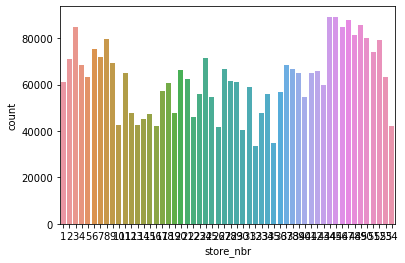

In [32]:
sns.countplot(x='store_nbr', data=Salesdf);

# The the above plot shows the number of stores according to each store type.

In [33]:
Salesdf.item_nbr.unique

<bound method Series.unique of 0            99197
1           103520
2           105574
3           105575
4           105737
            ...   
3359561    2089339
3359562    2106464
3359563    2110456
3359564    2113914
3359565    2116416
Name: item_nbr, Length: 3359566, dtype: int64>

In [34]:
x=itemfreq(Salesdf.item_nbr)
x=x[x[:,1].argsort()[::-1]]
x

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[2042947,    1726],
       [ 502331,    1724],
       [ 314384,    1723],
       ...,
       [1981370,       1],
       [1418842,       1],
       [1066900,       1]], dtype=int64)

In [35]:
x[:,0][0:10]

array([2042947,  502331,  314384,  323013,  364606,  222879, 2042941,
        414750, 1162382, 1418845], dtype=int64)

In [36]:
s=Salesdf.item_nbr.as_matrix()
s

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([  99197,  103520,  105574, ..., 2110456, 2113914, 2116416],
      dtype=int64)

In [37]:
t=s.reshape(s.shape[0],1)
t

array([[  99197],
       [ 103520],
       [ 105574],
       ...,
       [2110456],
       [2113914],
       [2116416]], dtype=int64)

In [38]:
t1=np.where(t==x)
t1

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

# 6. Product Purchase Trend

##  6.a. Fetching the N most purchased products

In [148]:
#Fetching the N most purchased products#
def N_most_labels(data, variable , N , all='TRUE'):
    labels_freq_pd = itemfreq(data[variable])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:N]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = data[variable].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_freq_pd, labels_filtered_index

label_freq, labels_filtered_index = N_most_labels(data = Salesdf, variable = "item_nbr", N = 20, all='FALSE')
print("labels_filtered_index[0].shape = ", labels_filtered_index[0].shape)

Salesdf_filtered = Salesdf.loc[labels_filtered_index[0],:]


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


labels_filtered_index[0].shape =  (34207,)


The number of most purchased products gives us the idea of looking for the sales for those products.

The code in the document by Source Kaggle is licensed under the MIT License https://opensource.org/licenses/MIT

In [149]:
label_freq[0:10]

array([[2042947,    1726],
       [ 502331,    1724],
       [ 314384,    1723],
       [ 323013,    1722],
       [ 364606,    1722],
       [ 222879,    1720],
       [2042941,    1719],
       [ 414750,    1716],
       [1162382,    1715],
       [1418845,    1715]], dtype=int64)

In [150]:
Salesdf_filtered.sample(3)

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico
1170515,2017-07-26,6,1052563,13.0,False,Quito,D,13,GROCERY I,0,NaN,NaN,NaN,48.580
1569646,2017-07-29,54,581078,9.0,True,El Carmen,C,3,CLEANING,0,NaN,NaN,NaN,49.965
2166976,2017-08-04,34,314384,16.0,True,Guayaquil,B,6,GROCERY I,0,NaN,NaN,NaN,49.570


In [151]:
#Fill in cells if there is no holiday by the value : "no_holyday"
na_index_Salesdf = Salesdf_filtered[Salesdf_filtered['type_y'].isnull() == True].index.values
print("Size of na_index_Salesdf : ", len(na_index_Salesdf), '\n')

Salesdf_filtered.loc[Salesdf_filtered['type_y'].isnull(), 'type_y'] = "no_holyday"
Salesdf_filtered.loc[Salesdf_filtered['locale'].isnull(), 'locale'] = "no_locale"
Salesdf_filtered.loc[Salesdf_filtered['transferred'].isnull(), 'transferred'] = "no_holyday"
    
#check is there is NA
Salesdf_filtered.isnull().sum()

Size of na_index_Salesdf :  26729 



date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
city           0
type_x         0
cluster        0
family         0
perishable     0
type_y         0
locale         0
transferred    0
dcoilwtico     0
dtype: int64

In [152]:
def get_month_year(df):
    df['month'] = df.date.apply(lambda x: x.split('-')[1])
    df['year'] = df.date.apply(lambda x: x.split('-')[0])
    
    return df

get_month_year(Salesdf_filtered);

In [153]:
Salesdf_filtered['date'] = pd.to_datetime(Salesdf_filtered['date'])
Salesdf_filtered['day'] = Salesdf_filtered['date'].dt.weekday_name
Salesdf_filtered = Salesdf_filtered.drop('date', axis=1)

In [154]:
Salesdf_filtered.sample(10)

,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico,month,year,day
1929686,16,2081064,13.0,False,Santo Domingo,C,3,PREPARED FOODS,1,no_holyday,no_locale,no_holyday,49.6000,08,2017,Wednesday
648779,9,502331,17.0,False,Quito,B,6,BREAD/BAKERY,1,no_holyday,no_locale,no_holyday,45.7800,07,2017,Friday
2721464,46,2042947,46.0,False,Quito,A,14,BEVERAGES,0,no_holyday,no_locale,no_holyday,49.5900,08,2017,Wednesday
372968,26,314384,4.0,False,Guayaquil,D,10,GROCERY I,0,no_holyday,no_locale,no_holyday,46.4000,07,2017,Tuesday
1789999,1,1463860,5.0,False,Quito,D,13,BEVERAGES,0,no_holyday,no_locale,no_holyday,49.1900,08,2017,Tuesday
2181142,42,222879,9.0,False,Cuenca,D,2,GROCERY I,0,no_holyday,no_locale,no_holyday,49.5700,08,2017,Friday
3161794,4,1157564,13.0,False,Quito,D,9,GROCERY I,0,no_holyday,no_locale,no_holyday,47.5900,08,2017,Monday
571233,23,2010511,4.0,False,Ambato,D,9,GROCERY I,0,no_holyday,no_locale,no_holyday,46.7300,07,2017,Thursday
1514677,29,314384,16.0,False,Guayaquil,E,10,GROCERY I,0,no_holyday,no_locale,no_holyday,49.9650,07,2017,Saturday
899927,31,261052,24.0,False,Babahoyo,B,10,GROCERY I,0,Holiday,Local,False,46.1025,07,2017,Sunday


In [155]:
strain = Salesdf.sample(frac=0.01,replace=True)

# 7. Exploratory Data Analysis

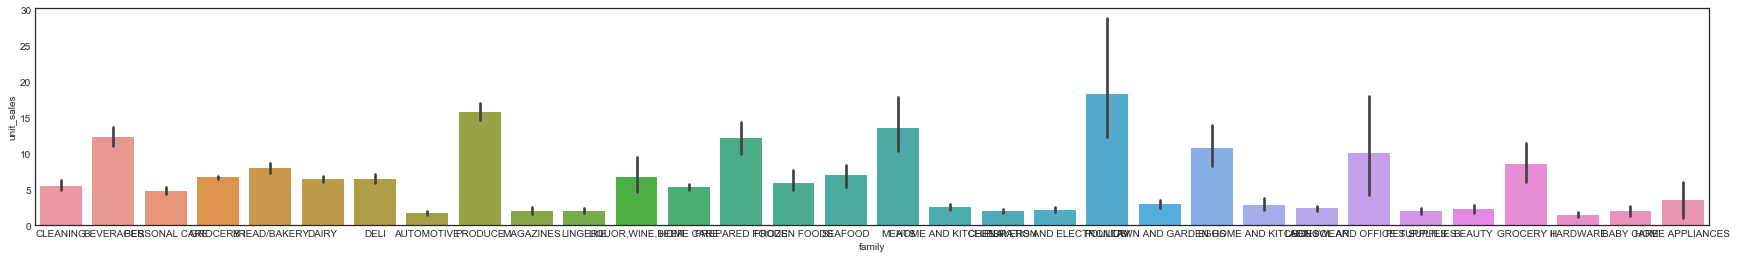

In [156]:
# Plotting Sales per Item Family
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.barplot(x='family', y='unit_sales', data=strain, ax=axis1)

# The above plot shows the sales of products per Item family. The average unit_sales ranges somewhere between 0 to 20 with the maximum for the Food and Beverages item family.

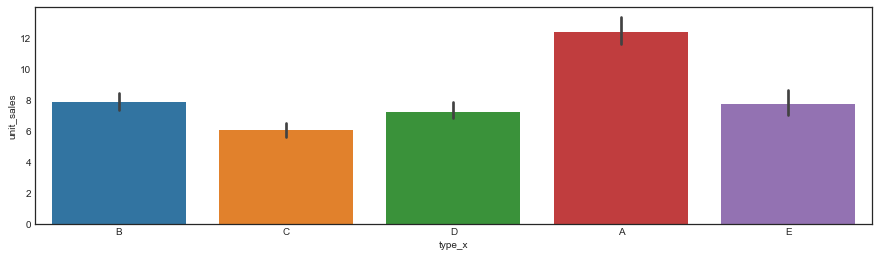

In [157]:
# Plotting Sales per Store Type
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='type_x', y='unit_sales', data=strain, ax=axis1)

# The bar plot of Total Sales per store type shows that Store type B has the maximum sales over other store types.

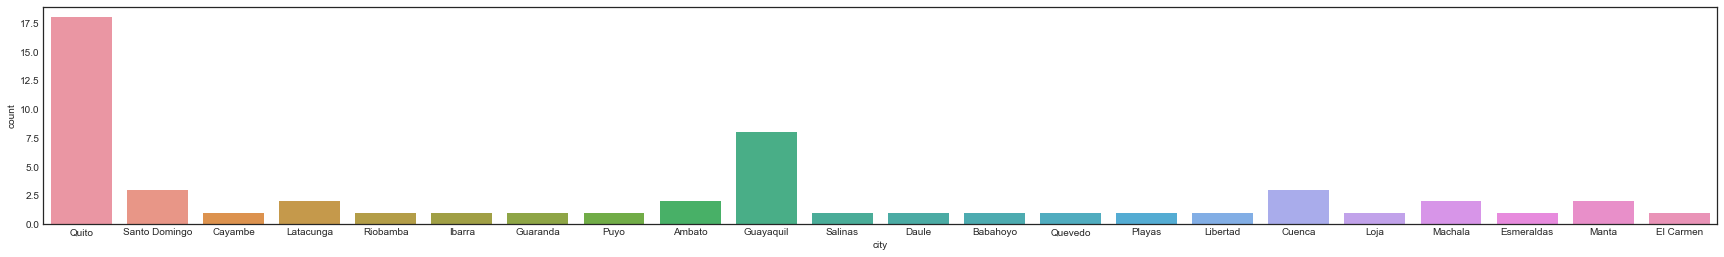

In [158]:
# Plotting Stores in Cities
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.countplot(x=stores['city'], data=stores, ax=axis1)

# The City of Quito has the most number of Stores and the second being the city of Guayaquil.

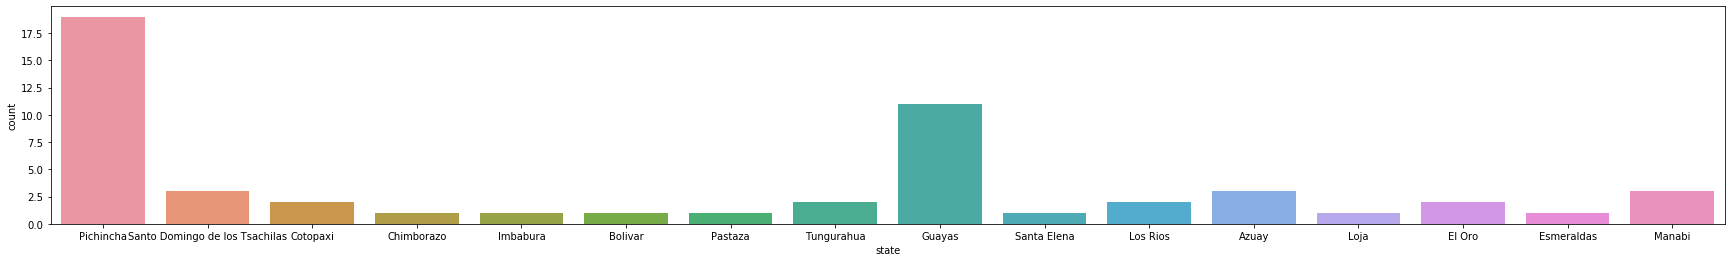

In [51]:
# Plotting Stores in States
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.countplot(x=stores['state'], data=stores, ax=axis1)

# The States of Pichincha Santo and the state of Guayas has the most number of Stores.

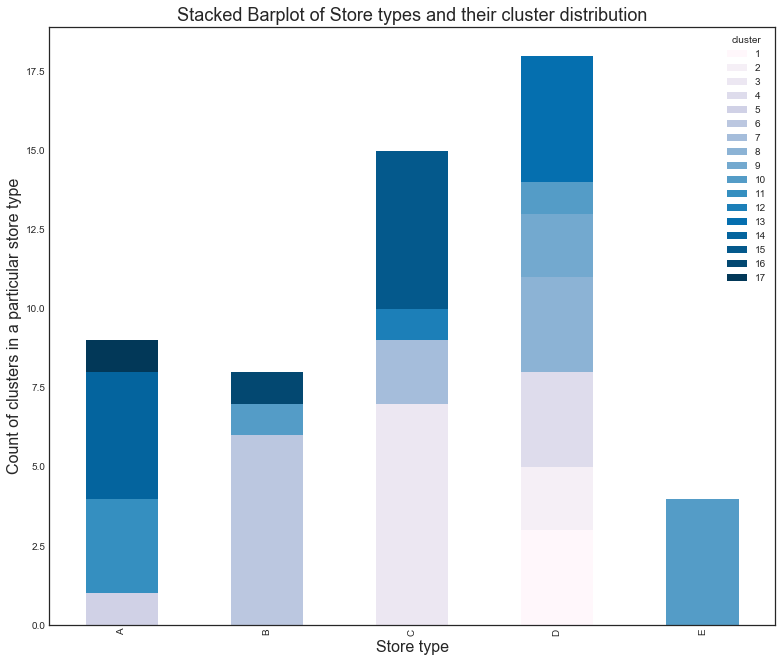

In [52]:
# Stacked Barplots of Types against clusters
plt.style.use('seaborn-white')
#plt.style.use('dark_background')
type_cluster = stores.groupby(['type','cluster']).size()
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types and their cluster distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show()

# The above bar plot shows the cluster distribution across the store types.

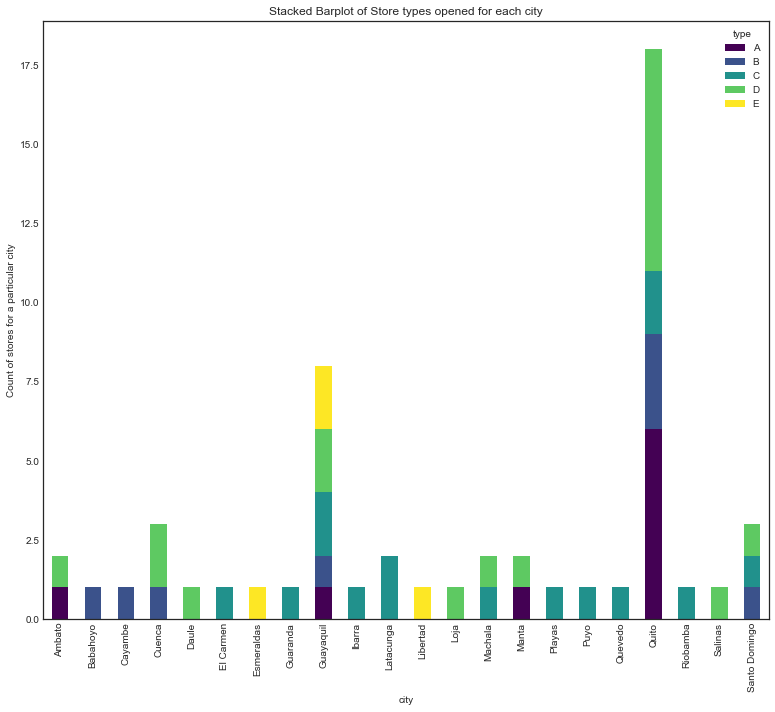

In [53]:
# Stacked barplot of types of stores across the different cities
plt.style.use('seaborn-white')
city_cluster = stores.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()

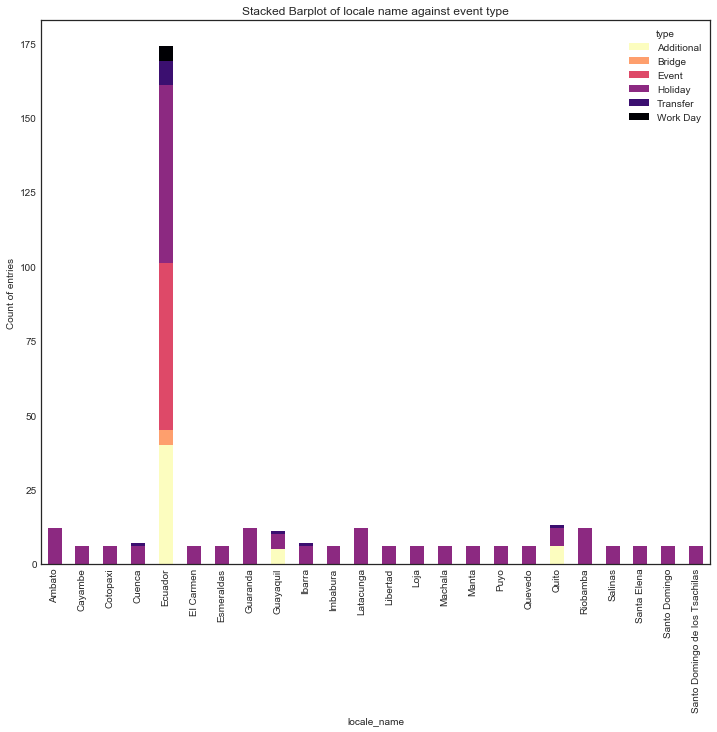

In [54]:
# Holiday Events data
plt.style.use('seaborn-white')
# plt.style.use('dark_background')
holiday_local_type = holidays.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'magma_r', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

# 8. Data Transformation Techniques

# 8.a One hot Encoding

## What is One Hot Encoding?
A one hot encoding is a representation of categorical variables as binary vectors.
This first requires that the categorical values be mapped to integer values.
Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

## Why Use a One Hot Encoding?
A one hot encoding allows the representation of categorical data to be more expressive.
Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers. This is required for both input and output variables that are categorical.


## The text in the document by Source Wikipedia is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/


In [55]:
## One hot encoding using get_dummies on pandas dataframe.
dummy_variables = ['onpromotion','city','type_x','cluster','store_nbr','item_nbr',
                'family','perishable','type_y', 'locale', 'transferred', 'month', 'day']

for var in dummy_variables:
    dummy = pd.get_dummies(Salesdf_filtered[var], prefix = var, drop_first = False)
    Salesdf_filtered = pd.concat([Salesdf_filtered, dummy], axis = 1)

Salesdf_filtered = Salesdf_filtered.drop(dummy_variables, axis = 1)
Salesdf_filtered = Salesdf_filtered.drop(['year'], axis = 1)

In [56]:
Salesdf_filtered.info()
#Salesdf_filtered.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34207 entries, 112 to 3359551
Columns: 148 entries, unit_sales to day_Wednesday
dtypes: float64(2), uint8(146)
memory usage: 5.5 MB


In [57]:
Salesdf_filtered.head()

,unit_sales,dcoilwtico,onpromotion_False,onpromotion_True,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,...,transferred_no_holyday,month_07,month_08,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
112,4.0,46.02,1,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
131,6.0,46.02,1,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
147,26.0,46.02,1,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
180,35.0,46.02,1,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
204,6.0,46.02,0,1,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0


# The above dataframe contains data after the one hot encoding technique is applied to the data.

In [58]:
#Re-scale
#We keep this value to re-scale the predicted unit_sales values in the following lines of code.
min_train, max_train = Salesdf_filtered['unit_sales'].min(), Salesdf_filtered['unit_sales'].max()

In [59]:
scalable_variables = ['unit_sales','dcoilwtico']

for var in scalable_variables:
    mini, maxi = Salesdf_filtered[var].min(), Salesdf_filtered[var].max()
    Salesdf_filtered.loc[:,var] = (Salesdf_filtered[var] - mini) / (maxi - mini)

In [60]:
print('Shape : ', Salesdf_filtered.shape)
Salesdf_filtered.sample(10)

Shape :  (34207, 148)


,unit_sales,dcoilwtico,onpromotion_False,onpromotion_True,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,...,transferred_no_holyday,month_07,month_08,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
1953525,0.015167,0.862302,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
1217106,0.005753,0.632054,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
298208,0.015167,0.054176,0,1,0,0,0,1,0,0,...,1,1,0,0,1,0,0,0,0,0
2631177,0.010460,0.742664,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
1343632,0.017259,0.738149,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
2898878,0.010983,0.683973,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1870312,0.014644,0.769752,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
480640,0.022490,0.297968,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
919943,0.014121,0.072799,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1837502,0.007322,0.769752,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0


In [61]:
Salesdf_filtered.isnull().sum()


unit_sales           0
dcoilwtico           0
onpromotion_False    0
onpromotion_True     0
city_Ambato          0
                    ..
day_Saturday         0
day_Sunday           0
day_Thursday         0
day_Tuesday          0
day_Wednesday        0
Length: 148, dtype: int64

In [62]:
#train database without unit_sales
Salesdf_filtered = Salesdf_filtered.reset_index(drop=True)  #we reset the index
y = Salesdf_filtered['unit_sales']
X = Salesdf_filtered.drop(['unit_sales'], axis = 1)

print('Shape X :', X.shape)
print('Shape y :', y.shape)

Shape X : (34207, 147)
Shape y : (34207,)


In [63]:
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test, random_state=15)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (27365, 147)
y_train shape : (27365,)
X_test shape : (6842, 147)
y_test shape : (6842,)


# 9. Regression Model fitting techniques.

# 9.a. Linear Regression

## Linear Regression

Linear Regression is a linear approach for modelling the relationship between a scalar dependent variable y and one or more explanatory variables (or independent variables) denoted X. The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression.

Linear regression models are often fitted using the least squares approach, but they may also be fitted in other ways, such as by minimizing the "lack of fit" in some other norm (as with least absolute deviations regression), or by minimizing a penalized version of the least squares cost function as in ridge regression (L2-norm penalty) and lasso (L1-norm penalty). 


## The text in the document by Source Wikipedia is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

In [64]:
# Fit the linear model
model = linear_model.LinearRegression()
results = model.fit(X_train, y_train)
print(results)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [65]:
# Print the coefficients
print (results.intercept_, results.coef_)

-710399723595.58 [ 7.10723568e-03 -5.86474547e+09 -5.86474547e+09  7.39039246e+09
 -3.69689845e+09 -1.42792188e+10 -8.78629983e+10  8.89765236e+10
 -8.19559665e+09  9.59401539e+09 -1.37822965e+10 -1.44282242e+10
  2.39059359e+08 -6.51219412e+10 -3.00310445e+10 -1.12197068e+09
 -3.55413921e+09 -1.18275334e+10 -6.54792935e+10 -1.87068548e+11
 -2.78807153e+11  4.46856851e+10 -1.91292476e+09 -2.82125930e+09
 -5.20058081e+10  3.74920212e+10 -1.37539047e+11  3.71913623e+10
  5.07953461e+10 -3.45603027e+10 -1.26636716e+11  9.08862932e+10
  1.55636440e+10  1.37650244e+11 -6.28582038e+10  1.91171733e+11
  3.95977166e+10 -9.34314107e+10 -2.95578062e+10  6.01187821e+10
  9.21777577e+08 -4.81359796e+10 -5.46080865e+10 -2.93825237e+10
 -1.82541164e+09  5.17385981e+10  1.51302538e+09 -2.13053404e+10
 -2.13053404e+10  1.75179838e+10 -4.63556207e+10 -1.16872178e+11
 -2.13053404e+10  1.75179838e+10  1.75179838e+10 -7.87507664e+10
 -6.04840315e+10 -1.97858624e+10  4.93235948e+10  4.93235948e+10
 -5.5308

In [67]:
import statsmodels.api as sm
import statsmodels.regression.linear_model as sm
model = sm.OLS(y_train, X_train)
results = model.fit()
# Statsmodels gives R-like statistical output
results.summary()
# Here the Ordinalry Least Squares method has given us the r^2 value of 0.354 which is poor for model to be predicted on these variables.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             unit_sales   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     184.9
Date:                Fri, 27 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:28:57   Log-Likelihood:                 65919.
No. Observations:               27365   AIC:                        -1.317e+05
Df Residuals:                   27279   BIC:                        -1.310e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
dcoilwtico                 0.0072      0.000     14.956      0.000       0.006       0.008
onpromotion_False      -6.473e+09   1.15e+10     -0.564      0.573    -2.9e+10     1.6e+10
onpromotion_True       -6.473e+09   1.15e+10     -0.564      0.573    -2.9e+10     1.6e+10
city_Ambato            -1.962e+10   1.87e+10     -1.048      0.295   -5.63e+10    1.71e+10
city_Babahoyo          -9.445e+08   1.01e+09     -0.939      0.348   -2.92e+09    1.03e+09
city_Cayambe           -1.482e+09   1.54e+09     -0.966      0.334   -4.49e+09    1.53e+09
city_Cuenca            -2.351e+09   2.41e+09     -0.974      0.330   -7.08e+09    2.38e+09
city_Daule             -8.772e+08   8.79e+08     -0.998      0.318    -2.6e+09    8.46e+08
city_El Carmen         -6.116e+08   6.09e+08     -1.005      0.315    -1.8e+09    5.81e+08
city_Esmeraldas        -6.571e+08   7.49e+08     -0.877      0.380   -2.13e+09    8.11e+08
city_Guaranda          -7.652e+08   8.08e+08     -0.947      0.344   -2.35e+09    8.18e+08
city_Guayaquil         -1.566e+09   1.68e+09     -0.932      0.351   -4.86e+09    1.73e+09
city_Ibarra            -7.711e+08   8.15e+08     -0.946      0.344   -2.37e+09    8.27e+08
city_Latacunga         -8.919e+08   9.77e+08     -0.913      0.361   -2.81e+09    1.02e+09
city_Libertad          -6.603e+08   7.66e+08     -0.862      0.389   -2.16e+09    8.42e+08
city_Loja              -8.174e+08   8.95e+08     -0.914      0.361   -2.57e+09    9.36e+08
city_Machala           -8.782e+08   9.54e+08     -0.921      0.357   -2.75e+09    9.91e+08
city_Manta             -3.253e+09   3.27e+09     -0.996      0.319   -9.65e+09    3.15e+09
city_Playas             -5.28e+08   5.82e+08     -0.908      0.364   -1.67e+09    6.12e+08
city_Puyo              -4.657e+08   5.78e+08     -0.805      0.421    -1.6e+09    6.68e+08
city_Quevedo           -6.087e+08   6.82e+08     -0.893      0.372   -1.95e+09    7.28e+08
city_Quito             -4.168e+09    4.2e+09     -0.993      0.321   -1.24e+10    4.06e+09
city_Riobamba          -3.461e+08   4.38e+08     -0.791      0.429    -1.2e+09    5.12e+08
city_Salinas            -6.74e+08   7.34e+08     -0.919      0.358   -2.11e+09    7.64e+08
city_Santo Domingo     -1.289e+09   1.37e+09     -0.943      0.346   -3.97e+09    1.39e+09
type_x_A                1.748e+09    1.5e+09      1.166      0.244   -1.19e+09    4.69e+09
type_x_B                4.271e+08   8.85e+08      0.483      0.629   -1.31e+09    2.16e+09
type_x_C               -5.549e+08    1.6e+09     -0.347      0.729   -3.69e+09    2.58e+09
type_x_D                1.312e+09   1.29e+09      1.015      0.310   -1.22e+09    3.84e+09
type_x_E                1.368e+08   7.82e+08      0.175      0.861    -1.4e+09    1.67e+09
cluster_1              -1.928e+09   2.01e+09     -0.957      0.338   -5.88e+09  

# The Linear regression model gives a low R- square value of 0.354

## Checking for VIF for eliminating multicollinearity and overfitting

In [68]:
#Implementing VIF (Variance Inflation Factor) to check whether the selected independent variables are correct for prediction 
# or not. Also, 'item_nbr', 'perishable' and 'dcoilwtico' had very close levels of co-relation with price which makes us to investigate whether all 
# three are important or not.
indep=['dcoilwtico','perishable','item_nbr','store_nbr','cluster']
X=Salesdf[indep]

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
thresh=10 #Setting a threshold of 10 as a sign of serious and sever multi-collinearity
for i in np.arange(0,len(indep)):
    vif=[variance_inflation_factor(X[indep].values,ix)
    for ix in range(X[indep].shape[1])]
    maxloc=vif.index(max(vif))
    if max(vif) > thresh:
        print ("vif :", vif)
        print( X[indep].columns[maxloc] )
        del indep[maxloc]
    else:
        break
        
    print ('Final variables: ', indep)

vif : [11.477700032259934, 1.3502134941660437, 4.9743199134182285, 4.008314266332862, 4.624524419190841]
dcoilwtico
Final variables:  ['perishable', 'item_nbr', 'store_nbr', 'cluster']


In [70]:
X[indep].head(5)

,perishable,item_nbr,store_nbr,cluster
0,0,99197,1,13
1,0,103520,1,13
2,0,105574,1,13
3,0,105575,1,13
4,0,105737,1,13


In [71]:
X=Salesdf[['perishable', 'item_nbr', 'store_nbr', 'cluster']]
y=Salesdf[["unit_sales"]]

## Cross Validation using Scikit Learn

R^2 value is basically dependant on the way the data is split. Hence, there may be times when the R^2 value may not be able to
represent the model's ability to generalize. For this we perform cross validation.

In [72]:
reg=linear_model.LinearRegression()
cv_results=cross_val_score(reg,X_train,y_train,cv=5)
print(cv_results)
print(np.mean(cv_results))
print(np.std(cv_results))
#Using cross validation of score 5

[0.40801004 0.32014689 0.36808983 0.34935282 0.37056641]
0.3632331987108618
0.028745168252796847


## Regularization

We perform regularization in order to alter the loss function to penalize it for having higher coefficients for each feature variable. And as we know, large coefficients leads to overfitting.

In [73]:
ridge = Ridge(alpha=0.1, normalize = True)
ridge.fit(X_train,y_train)
ridge_pred=ridge.predict(X_test)
ridge.score(X_test,y_test)
#The score is pretty much similar to the linear model built which ensures that the model has passed the Ridge regression test
# for regularization
#Ridge is used to penalize the loss function by adding the OLS loss function to the square of each coefficient multiplied by alpha.

0.31996853138885784

## 9.b DecisionTree Regressor

A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.



In [74]:
dtr=DecisionTreeRegressor(max_depth=10,min_samples_leaf=5,max_leaf_nodes=5)

In [75]:
dtr.fit(X_train,y_train)
y_pred=dtr.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

##using a decision tree greatly improves the accurancy of model prediction.

R2 score =  0.34151505635144486 / 1.0
MSE score =  0.0006105670432820245 / 0.0


## 9.c. ExtraTreesRegressor

Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the max_features randomly selected features and the best split among those is chosen.

In [76]:
etr = ExtraTreesRegressor()

# Choose some parameter combinations to try

parameters = {'n_estimators': [5,10,100],
              'criterion': ['mse'],
              'max_depth': [5,10,15], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,5]
             }
#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold

grid_obj = GridSearchCV(etr, parameters,
                        cv=3, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
etr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
etr.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  3.1min finished


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=15, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=5, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [77]:
y_pred = etr.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.7562605772159008 / 1.0
MSE score =  0.00022600252311916525 / 0.0


## 9.d Random Forest Regressor

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.Random decision forests correct for decision trees' habit of overfitting to their training set.

In [78]:
# Choose the type of classifier. 
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [5, 10, 100],
              'min_samples_leaf': [1,5]
             }


#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [79]:
y_pred = RFR.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.8319284962693574 / 1.0
MSE score =  0.00015584095290651276 / 0.0


In [80]:
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [5,10,100],
              'criterion': ['mse'],
              'max_depth': [5,10,15], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,5]
             }


#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  4.9min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [81]:
y_pred = RFR.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.8322038086381618 / 1.0
MSE score =  0.0001555856749983066 / 0.0


## 9.e. Gradient Boosting Regressor

The idea of boosting came out of the idea of whether a weak learner can be modified to become better.
A weak hypothesis or weak learner is defined as one whose performance is at least slightly better than random chance.
Hypothesis boosting was the idea of filtering observations, leaving those observations that the weak learner can handle and focusing on developing new weak learns to handle the remaining difficult observations.

## How Gradient Boosting Works

Gradient boosting involves three elements:

-- A loss function to be optimized.

-- A weak learner to make predictions.

-- An additive model to add weak learners to minimize the loss function.

In [82]:
#gbr = GradientBoostingRegressor(loss='huber',learning_rate=0.3,n_estimators=100,max_depth=5,min_samples_split=3)
gbr=GradientBoostingRegressor()

parameters = {'n_estimators': [5,10],
              'loss':['huber'],
              'criterion': ['mse'],
              'max_depth': [5,10], 
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,5]
             }

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(gbr, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gbr.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   21.8s finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [83]:
y_pred = gbr.predict(X_test)

print('R2 score using Gradient Boosting= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using Gradient Boosting= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using Gradient Boosting=  0.4377292183809933 / 1.0
MSE score using Gradient Boosting=  0.0005213543786662753 / 0.0


In [84]:
gbr = GradientBoostingRegressor(loss='ls',learning_rate=0.1,n_estimators=150,max_depth=10,min_samples_split=5)


parameters = {'n_estimators': [5,15,150],
              'loss':['ls','huber'],
              'criterion': ['mse'],
              'max_depth': [10,15], 
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,5]
             }

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(gbr, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gbr.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 12.4min finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [85]:
y_pred = RFR.predict(X_test)

print('R2 score using Gradient Boosting= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using Gradient Boosting= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using Gradient Boosting=  0.8322038086381618 / 1.0
MSE score using Gradient Boosting=  0.0001555856749983066 / 0.0


## 9.f. XGBOOST

XGBoost (eXtreme Gradient Boosting) is a direct application of Gradient Boosting for decision trees

Main advantages are as follows:
1. Easy to use
2. Computational efficiency
3. Model Accuracy
4. Feasibility — easy to tune parameters and modify objectives.

In [86]:
model=XGBRegressor(max_depth=5)

In [87]:
model.fit(X_train,y_train)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:58:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [88]:
y_pred=model.predict(X_test)

In [89]:
print('R2 score using XG Boost= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using XG Boost= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using XG Boost=  0.8190880578462724 / 1.0
MSE score using XG Boost=  0.00016774699358071266 / 0.0


## 10. LGBM

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. 

In [90]:

from lightgbm import LGBMRegressor
lgbm=LGBMRegressor(max_depth=5)
lgbm.fit(X_train,y_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [91]:
y_pred=lgbm.predict(X_test)

In [92]:
print('R2 score using LGBM = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using LGBM = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using LGBM =  0.765161514568798 / 1.0
MSE score using LGBM =  0.0002177493063153235 / 0.0


In [93]:
Salesdf.corr()


,store_nbr,item_nbr,unit_sales,cluster,perishable,dcoilwtico
store_nbr,1.000000,0.008584,0.049419,0.035167,0.004841,0.000081
item_nbr,0.008584,1.000000,0.024456,0.001199,0.044806,0.000774
unit_sales,0.049419,0.024456,1.000000,0.017562,0.051758,0.003918
cluster,0.035167,0.001199,0.017562,1.000000,-0.004240,0.001593
perishable,0.004841,0.044806,0.051758,-0.004240,1.000000,-0.000611
dcoilwtico,0.000081,0.000774,0.003918,0.001593,-0.000611,1.000000


## 11. Creating a neural network

Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function  by training on a dataset, where  is the number of dimensions for input and  is the number of dimensions for output.

The advantages of Multi-layer Perceptron are:

-- Capability to learn non-linear models.

-- Capability to learn models in real-time (on-line learning) using partial_fit.

In [94]:
# Convert data as np.array
features = np.array(X_train)
#targets = np.array(y_train.reshape(y_train.shape[0],1))
targets = np.array(y_train.values.reshape(y_train.shape[0],1))
features_validation= np.array(X_test)
#targets_validation = np.array(y_test.reshape(y_test.shape[0],1))
targets_validation = np.array(y_test.values.reshape(y_test.shape[0],1))

print(features[:10])
print(targets[:10])

[[0.62302483 1.         0.         ... 1.         0.         0.        ]
 [0.86004515 0.         1.         ... 0.         0.         1.        ]
 [0.13995485 1.         0.         ... 0.         1.         0.        ]
 ...
 [0.86004515 1.         0.         ... 0.         0.         1.        ]
 [0.74266366 1.         0.         ... 0.         1.         0.        ]
 [0.85553047 1.         0.         ... 0.         0.         0.        ]]
[[0.02301255]
 [0.01046025]
 [0.00679916]
 [0.01202929]
 [0.0083682 ]
 [0.00889121]
 [0.02196653]
 [0.01464435]
 [0.00627615]
 [0.00941423]]


In [95]:
# Building the model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(1))

# Compiling the model
model.compile(loss = 'mse', optimizer='adam', metrics=['mse']) #mse: mean_square_error
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                4736      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


Step :  0 / 1000
27365/27365 [==============================] - 0s 11us/step
Training MSE: 6.466561171691865e-05
6842/6842 [==============================] - 0s 11us/step
Validation MSE: 0.00013960491924080998 

Step :  250 / 1000
27365/27365 [==============================] - 0s 10us/step
Training MSE: 7.213683420559391e-05
6842/6842 [==============================] - 0s 10us/step
Validation MSE: 0.0001698127161944285 

Step :  500 / 1000
27365/27365 [==============================] - 0s 11us/step
Training MSE: 7.03627010807395e-05
6842/6842 [==============================] - 0s 11us/step
Validation MSE: 0.0001417695893906057 

Step :  750 / 1000
27365/27365 [==============================] - 0s 11us/step
Training MSE: 7.236996316350996e-05
6842/6842 [==============================] - 0s 10us/step
Validation MSE: 0.0001428297982783988 



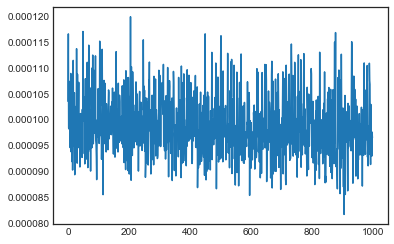

In [101]:
# Training the model
epochs_tot = 1000
epochs_step = 250
epochs_ratio = int(epochs_tot / epochs_step)
hist =np.array([])

for i in range(epochs_ratio):
    history = model.fit(features, targets, epochs=epochs_step, batch_size=100, verbose=0)
    
    # Evaluating the model on the training and testing set
    print("Step : " , i * epochs_step, "/", epochs_tot)
    score = model.evaluate(features, targets)
    print("Training MSE:", score[1])
    score = model.evaluate(features_validation, targets_validation)
    print("Validation MSE:", score[1], "\n")
    hist = np.concatenate((hist, np.array(history.history['mse'])), axis = 0)#mse: mean_square_error
    
# plot metrics
plt.plot(hist)
plt.show()

In [102]:
y_pred = model.predict(features_validation, verbose=0)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.845960790583688 / 1.0
MSE score =  0.00014282978760561454 / 0.0


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


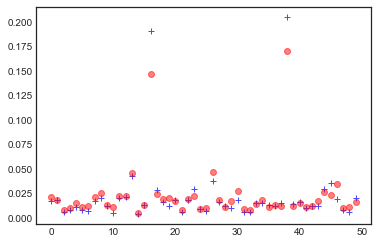

In [103]:
#Lets plot the  first 50 predictions
plt.plot(y_test.as_matrix()[0:50], '+', color ='blue', alpha=0.7)
plt.plot(y_pred[0:50], 'ro', color ='red', alpha=0.5)
plt.show()

## Light GBM

In [104]:
df_train = pd.read_csv(
    'train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

In [105]:
df_train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2016-01-01,25,105574,2.564949,False
1,2016-01-01,25,105575,2.302585,False
2,2016-01-01,25,105857,1.386294,False
3,2016-01-01,25,108634,1.386294,False
4,2016-01-01,25,108701,1.098612,True


In [106]:
df_train.shape

(59038132, 5)

In [107]:
df_train.tail()

,date,store_nbr,item_nbr,unit_sales,onpromotion
59038127,2017-08-15,54,2089339,1.609438,False
59038128,2017-08-15,54,2106464,0.693147,True
59038129,2017-08-15,54,2110456,5.262690,False
59038130,2017-08-15,54,2113914,5.293305,True
59038131,2017-08-15,54,2116416,1.098612,False


In [108]:
df_test = pd.read_csv(
    "test.csv", usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]  # , date_parser=parser
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

In [109]:
#we want to predict unit sales for last 15 days of Aug 2017
df_test.head()

id  onpromotion
store_nbr item_nbr date                              
1         96995    2017-08-16  125497040        False
          99197    2017-08-16  125497041        False
          103501   2017-08-16  125497042        False
          103520   2017-08-16  125497043        False
          103665   2017-08-16  125497044        False

In [110]:
items = pd.read_csv(
    "items.csv",
).set_index("item_nbr")

In [111]:
items.shape

(4100, 3)

In [112]:
df_2017 = df_train[df_train.date.isin(
    pd.date_range("2017-05-31", periods=7 * 11))].copy()
del df_train
#dates range from May 31st to 15th Aug~ 77 days

In [113]:
df_2017.shape

(8125670, 5)

In [114]:
df_2017.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
50912462,2017-05-31,1,96995,0.693147,False
50912463,2017-05-31,1,99197,0.693147,False
50912464,2017-05-31,1,103520,1.386294,False
50912465,2017-05-31,1,103665,2.197225,False
50912466,2017-05-31,1,105574,1.386294,False


In [115]:
df_2017.isnull().sum()

date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

In [116]:
promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
#pivots the table and we want last level of index which is date in our case

In [117]:
promo_2017_train.head()

onpromotion                                              \
date                2017-05-31 2017-06-01 2017-06-02 2017-06-03 2017-06-04   
store_nbr item_nbr                                                           
1         96995          False      False      False      False      False   
          99197          False      False      False      False      False   
          103520         False      False      False      False      False   
          103665         False      False      False      False      False   
          105574         False      False      False      False      False   

                                                                           \
date               2017-06-05 2017-06-06 2017-06-07 2017-06-08 2017-06-09   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   
          105574        False      False      False      False      False   

                    ...                                              \
date                ... 2017-08-06 2017-08-07 2017-08-08 2017-08-09   
store_nbr item_nbr  ...                                               
1         96995     ...      False      False      False      False   
          99197     ...      False      False      False      False   
          103520    ...      False      False      False      False   
          103665    ...      False      False      False      False   
          105574    ...      False      False      False      False   

                                                                           \
date               2017-08-10 2017-08-11 2017-08-12 2017-08-13 2017-08-14   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   
          105574        False      False      False      False      False   

                               
date               2017-08-15  
store_nbr item_nbr             
1         96995         False  
          99197         False  
          103520        False  
          103665        False  
          105574        False  

[5 rows x 77 columns]

In [118]:
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)

In [119]:
promo_2017_train.columns

DatetimeIndex(['2017-05-31', '2017-06-01', '2017-06-02', '2017-06-03',
               '2017-06-04', '2017-06-05', '2017-06-06', '2017-06-07',
               '2017-06-08', '2017-06-09', '2017-06-10', '2017-06-11',
               '2017-06-12', '2017-06-13', '2017-06-14', '2017-06-15',
               '2017-06-16', '2017-06-17', '2017-06-18', '2017-06-19',
               '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',
               '2017-06-24', '2017-06-25', '2017-06-26', '2017-06-27',
               '2017-06-28', '2017-06-29', '2017-06-30', '2017-07-01',
               '2017-07-02', '2017-07-03', '2017-07-04', '2017-07-05',
               '2017-07-06', '2017-07-07', '2017-07-08', '2017-07-09',
               '2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13',
               '2017-07-14', '2017-07-15', '2017-07-16', '2017-07-17',
               '2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21',
               '2017-07-22', '2017-07-23', '2017-07-24', '2017-07-25',
      

In [120]:
#Repeat same steps for test dataset
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)

In [121]:
promo_2017_test.head()
promo_2017_test.shape

(210654, 16)

In [122]:
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)
#Reseting the index same as promo_2017_train
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)

In [123]:
del promo_2017_test,promo_2017_train

In [124]:
df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

In [125]:
promo_2017.head()

date                2017-05-31  2017-06-01  2017-06-02  2017-06-03  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-06-04  2017-06-05  2017-06-06  2017-06-07  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-06-08  2017-06-09  ...  2017-08-22  2017-08-23  \
store_nbr item_nbr                          ...                           
1         96995          False       False  ...       False       False   
          99197          False       False  ...       False       False   
          103520         False       False  ...       False       False   
          103665         False       False  ...       False       False   
          105574         False       False  ...       False       False   

date                2017-08-24  2017-08-25  2017-08-26  2017-08-27  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                  
1         96995          False       False       False       False  
          99197          False       False       False       False  
          103520         False       False       False       False  
          103665         False       False       False       False  
          105574         False       False       False       False  

[5 rows x 93 columns]

In [126]:
items = items.reindex(df_2017.index.get_level_values(1))

In [127]:
items.head()

,family,class,perishable
item_nbr,,,
96995,GROCERY I,1093,0
99197,GROCERY I,1067,0
103520,GROCERY I,1028,0
103665,BREAD/BAKERY,2712,1
105574,GROCERY I,1045,0


In [128]:
def get_timespan(df, dt, minus, periods):
    return df[
        pd.date_range(dt - timedelta(days=minus), periods=periods)
    ]

In [129]:
def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values
    })
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

In [130]:
print("Preparing dataset...")
t2017 = date(2017, 6, 21)
X_l, y_l = [], []
for i in range(4):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(
        t2017 + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26))
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)

Preparing dataset...


In [131]:
print("Training and predicting models...")
params = {
    'num_leaves': 2**5 - 1,
    'objective': 'regression_l2',
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}


Training and predicting models...


In [132]:
MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []

In [133]:
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items["perishable"]] * 4) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items["perishable"] * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )
    print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))
    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

Step 1


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.345309	valid_1's l2: 0.34144
[100]	training's l2: 0.333342	valid_1's l2: 0.329948
[150]	training's l2: 0.331335	valid_1's l2: 0.328626
[200]	training's l2: 0.33032	valid_1's l2: 0.328266
[250]	training's l2: 0.329484	valid_1's l2: 0.327836
[300]	training's l2: 0.328788	valid_1's l2: 0.327612
[350]	training's l2: 0.328236	valid_1's l2: 0.327447
[400]	training's l2: 0.327652	valid_1's l2: 0.327325
[450]	training's l2: 0.327154	valid_1's l2: 0.327256
[500]	training's l2: 0.326674	valid_1's l2: 0.327193
[550]	training's l2: 0.326248	valid_1's l2: 0.327183
[600]	training's l2: 0.325826	valid_1's l2: 0.327141
[650]	training's l2: 0.325417	valid_1's l2: 0.327065
[700]	training's l2: 0.325027	valid_1's l2: 0.327018
[750]	training's l2: 0.324684	valid_1's l2: 0.327011
Early stopping, best iteration is:
[736]	training's l2: 0.324772	valid_1's l2: 0.326994
mean_7_2017: 1838843.28
mean_14_2017: 1795524.42
promo_0: 1

Step 8
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.387423	valid_1's l2: 0.45965
[100]	training's l2: 0.375405	valid_1's l2: 0.44196
[150]	training's l2: 0.37285	valid_1's l2: 0.439204
[200]	training's l2: 0.371502	valid_1's l2: 0.438333
[250]	training's l2: 0.37032	valid_1's l2: 0.43779
[300]	training's l2: 0.369393	valid_1's l2: 0.437293
[350]	training's l2: 0.368622	valid_1's l2: 0.437012
[400]	training's l2: 0.367933	valid_1's l2: 0.436803
[450]	training's l2: 0.367334	valid_1's l2: 0.436641
[500]	training's l2: 0.366759	valid_1's l2: 0.436351
[550]	training's l2: 0.366245	valid_1's l2: 0.436251
[600]	training's l2: 0.365747	valid_1's l2: 0.436214
[650]	training's l2: 0.36528	valid_1's l2: 0.436136
[700]	training's l2: 0.364821	valid_1's l2: 0.436062
[750]	training's l2: 0.364363	valid_1's l2: 0.435923
[800]	training's l2: 0.36396	valid_1's l2: 0.435949
Early stopping, best iteration is:
[777]	training's l2: 0.364128	valid_1's l2: 0.435883
mean

[500]	training's l2: 0.387841	valid_1's l2: 0.396546
[550]	training's l2: 0.387289	valid_1's l2: 0.396527
[600]	training's l2: 0.386747	valid_1's l2: 0.396478
Early stopping, best iteration is:
[584]	training's l2: 0.386893	valid_1's l2: 0.396448
mean_14_2017: 2641862.19
mean_7_2017: 565506.84
promo_14: 234889.41
mean_3_2017: 66075.23
promo_14_2017: 51858.91
promo_7: 29922.84
promo_0: 29759.80
promo_15: 19371.64
promo_13: 11638.52
promo_9: 10257.70
promo_12: 8979.95
promo_10: 6598.33
promo_2: 4391.81
promo_6: 4033.92
promo_11: 3483.20
promo_8: 3161.31
promo_4: 2506.13
promo_1: 2225.89
promo_5: 1698.90
promo_3: 1301.72
Step 16
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.418699	valid_1's l2: 0.431334
[100]	training's l2: 0.408347	valid_1's l2: 0.423344
[150]	training's l2: 0.40537	valid_1's l2: 0.422401
[200]	training's l2: 0.403705	valid_1's l2: 0.421863
[250]	training's l2: 0.40255	valid_1's l2: 0.421625
[300]	training's l2: 0.401536	valid_1's l2:

In [134]:
print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

Validation mse: 0.4139337633011243


In [135]:
print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


Making submission...


In [136]:
submission = df_test[["id"]].join(df_preds, how="left").fillna(0)

In [137]:
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('lgb.csv', float_format='%.4f', index=None)

# 12. Conclusion
We are getting following results on applying data set on different models:

Model                                    
R2 Score

Linear Regression                  
0.354

Decision Tree Regression           
0.705

Extra Tree Regression              
0.825

Random Forest Regression           
0.836

Gradient Boosting Regression       
0.836

XG Boost                           
0.797

LGBM                               
0.759

# 13. References and Attributions

[1] Cui, G., Wong, M. L., & Lui, H. K. (2006). Machine learning for direct marketing response models:
Bayesian networks with evolutionary programming.Management Science, 52(4), 597-612

[2] Taylor, E. L. (2014). Predicting Consumer Behavior. Research World, 2014(46), 67-68

[3] Morwitz, V. G., Steckel, J. H., & Gupta, A. (2007). When do purchase intentions predict sales?.
International Journal of Forecasting, 23(3), 347-364

[4] https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data

[5] https://en.wikipedia.org/wiki/Xgboost

[6] https://en.wikipedia.org/wiki/Random_forest

[7] https://en.wikipedia.org/wiki/Decision_tree

[8]https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vsxgboost/

[9] https://www.tutorialspoint.com/sales_forecasting/sales_forecasting_discussion.html

The text in the document by Source Wikipedia is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

The text in the document by Analytics Vidhya is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

The text in the document by towards data science is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

The code in the document by Source Kaggle is licensed under the MIT License https://opensource.org/licenses/MIT